In [1]:
from numpy import interp

import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Creating Dataframe

In [48]:
comp = pd.read_csv('C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data_store/processed/companies_full.csv')
comp = comp[comp.stage.notna() 
     & comp.name.notna() & comp["size_numeric"].notna()]
comp['market'] = comp['market'].apply(lambda row: str(row).replace(" ", "_"))

In [49]:
comp.head()

,Unnamed: 0,joined,kind,link,location,market,name,pitch,raised,size,stage,website,years,annual_raised,raised_2mil,raised_12mil,size_numeric
1,1,2012-05-01,Startup,https://angel.co/company/ginx,Las Vegas,Mobile_Commerce,*Ginx,\nImage based marketing and analytics \n,700000,1-10,Seed,ginxapp.com,7.627397,9.177443e+04,0,0,5.0
2,2,2011-09-01,Startup,https://angel.co/company/1-page,San Francisco,SaaS,1-Page,\nNext Generation Enterprise Recruitment Proce...,163000000,11-50,IPO,1-page.com,8.293151,1.965477e+07,1,1,25.0
3,3,2012-04-01,Startup,https://angel.co/company/121nexus,Cambridge,Politics,121nexus,\nThe information platform for physical things.\n,794000,1-10,-,121nexus.com,7.709589,1.029886e+05,0,0,5.0
5,5,2013-03-01,Startup,https://angel.co/company/1newtrack-com,Kyivs'ka oblast,Video_Streaming,1NewTrack.com,"\nDiscover 1 new track per day, personally sel...",70001,1-10,-,1NewTrack.com,6.794521,1.030257e+04,0,0,5.0
6,6,2012-10-01,Startup,https://angel.co/company/1world-1,Redwood City,Polling,1World Online,\nWe combine Native Advertising and Research o...,7280000,1-10,Series A,1worldonline.com,7.208219,1.009958e+06,1,0,5.0


### One hot encoding

In [50]:
seed = comp[(comp["stage"]=="Seed")]
seed_y = seed['raised_2mil']


In [51]:
seed.shape

(1912, 17)

In [52]:
comp.shape

(3673, 17)

In [53]:
seriesA = comp[(comp["stage"]=="Series A")]
seriesA_y = seriesA['raised_12mil']

In [54]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [55]:
def one_hot_market(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['market'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['market'],axis=1,inplace=True)
#     print(result.columns[(result == 0).sum() > 0.995*result.shape[0]])
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

def one_hot_location(dataframe):
    gen_onehot_features = pd.get_dummies(dataframe['location'])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop(['location'],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [56]:
seriesA['size'].value_counts()

11-50        285
51-200       136
1-10          94
201-500       15
501-1000       3
1001-5000      1
Name: size, dtype: int64

In [115]:
comp['stage'].value_counts()

Seed        1912
Series A     534
Acquired     419
Series B     283
Series C     185
-            167
Series D      68
Closed        49
Series E      25
IPO           16
Pre-Seed       7
Series F       6
Series G       2
Name: stage, dtype: int64

### Data for modeling

In [57]:
seed_x =one_hot(one_hot(seed[['location','size_numeric','years','market']],"location"),"market")


In [134]:
seed_final_all_features = seed_x 
seed_final_all_features['raised_2m'] = seed_y.to_frame()
seed_final_all_features.to_csv('../data_store/processed/seed_final_all_features.csv')   

In [59]:
seed_x.shape

(1912, 83)

In [60]:
seriesA_x =one_hot(one_hot(seriesA[['location','size_numeric','years','market']],"location"),"market")

In [61]:
for i in [seed_x, seed_y, seriesA_x, seriesA_y]:
    print(i.shape)

(1912, 83)
(1912,)
(534, 96)
(534,)


In [135]:
seriesA_final_all_features = seriesA_x 
seriesA_final_all_features['raised_2m'] = seriesA_y.to_frame()
seriesA_final_all_features.to_csv('../data_store/processed/seriesA_final_all_features.csv')   

In [62]:
rs = 1

In [63]:
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=rs)

In [64]:
seriesA_x_train, seriesA_x_test, seriesA_y_train, seriesA_y_test = train_test_split(seriesA_x, 
                                                                                    seriesA_y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=rs)

In [65]:
def split_downsample(X,y):
    var= y.name
    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X_train = upsampled.drop(var,axis=1)
    new_y_train = upsampled[var]
    
    return new_X_train, X_test, new_y_train, y_test

In [66]:
def downsample(X,y,rs=None):
    var= y.name
    
    joint = pd.concat([X, y], axis=1)
    negative = joint[joint[var]==0]
    positive = joint[joint[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        random_state = rs) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X = upsampled.drop(var,axis=1)
    new_y = upsampled[var]
    
    return new_X, new_y

In [67]:
downsample(seed_x_train, seed_y_train)[1].value_counts()

1    274
0    274
Name: raised_2mil, dtype: int64

In [68]:
def downsample_split(X,y):
    var= y.name
    #combine them for resampling
    train_data = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    
    X_train, X_test, y_train, y_test = train_test_split( 
        upsampled.drop(var,axis=1), upsampled[var], stratify=upsampled[var],
        test_size=0.33,)
    
    # check new class counts
#     print(y_train.value_counts())

    return X_train, X_test, y_train, y_test

### Training Set variable selection (Logistic Regression p-value)

In [69]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest

In [70]:
def get_feat(method, k, x, y):
    select = SelectKBest(method, k)
    _ = select.fit_transform(x, y)
    return [x.columns[i] for i, val in enumerate(select.get_support()) if val]

In [71]:
num_features = 10

#### seed

In [72]:
mutual_seed = get_feat(mutual_info_classif, num_features, seed_x_train, seed_y_train)

In [73]:
chi2_seed = get_feat(chi2, num_features, seed_x_train, seed_y_train)

In [74]:
f_seed = get_feat(f_classif, num_features, seed_x_train, seed_y_train)

In [75]:
chi2_seed

['size_numeric',
 'years',
 'Austin',
 'San Francisco',
 'Seattle',
 'Big_Data_Analytics',
 'Crowdsourcing',
 'Health_Care_Information_Technology',
 'Mobile_Games',
 'Predictive_Analytics']

In [76]:
f_seed

['size_numeric',
 'years',
 'Austin',
 'San Francisco',
 'Seattle',
 'Big_Data_Analytics',
 'Crowdsourcing',
 'Health_Care_Information_Technology',
 'Mobile_Games',
 'Predictive_Analytics']

In [77]:
mutual_seed

['size_numeric',
 'years',
 'Las Vegas',
 'Miami',
 'San Francisco',
 'Vancouver',
 'Big_Data_Analytics',
 'Education',
 'Hospitality',
 'Mobile_Health']

#### Series A

In [78]:
mutual_seriesA = get_feat(mutual_info_classif, num_features, seriesA_x_train, seriesA_y_train)

In [79]:
chi2_seriesA = get_feat(chi2, num_features, seriesA_x_train, seriesA_y_train)

In [80]:
f_seriesA = get_feat(f_classif, num_features, seriesA_x_train, seriesA_y_train)

In [81]:
f_seriesA

['size_numeric',
 'years',
 'San Mateo',
 'Sydney',
 'Washington DC',
 'Application_Platforms',
 'Banking',
 'Cloud_Infrastructure',
 'Consumer_Electronics',
 'Investment_Management']

In [82]:
chi2_seriesA

['size_numeric',
 'years',
 'San Mateo',
 'Sydney',
 'Washington DC',
 'Application_Platforms',
 'Banking',
 'Cloud_Infrastructure',
 'Consumer_Electronics',
 'Investment_Management']

In [83]:
mutual_seriesA

['size_numeric',
 'years',
 'Seattle',
 'São Paulo',
 'Cloud_Infrastructure',
 'Finance_Technology',
 'Human_Resources',
 'Logistics',
 'Medical_Devices',
 'Social_Media']

In [87]:
import statsmodels.api as sm
import numpy as np

def logiVarSelect(x, y, sig_lvl, columns):
    while True:
        logi = sm.Logit(y, x).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed
        maxP = max(logi.pvalues)
        if maxP > sig_lvl:
            loc = list(logi.pvalues).index(maxP)
            x = np.delete(x, loc, 1)
            columns = np.delete(columns, loc)
        else: 
            return columns

In [88]:
selected_columns_seed = seed_x_train.columns.values
selected_columns_seriesA = seriesA_x_train.columns.values

SL = 0.05

In [89]:
p_seed = logiVarSelect(seed_x_train.values, seed_y_train.values, SL, selected_columns_seed)

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.406199
         Iterations: 215
         Function evaluations: 224
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: 0.408728
         Iterations: 213
         Function evaluations: 222
         Gradient evaluations: 219


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.408728
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218
Optimization terminated successfully.
         Current function value: 0.408728
         Iterations: 224
         Function evaluations: 233
         Gradient evaluations: 230


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.410405
         Iterations: 214
         Function evaluations: 223
         Gradient evaluations: 220
Optimization terminated successfully.
         Current function value: 0.410405
         Iterations: 225
         Function evaluations: 234
         Gradient evaluations: 231
Optimization terminated successfully.
         Current function value: 0.410406
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.411542
         Iterations: 210
         Function evaluations: 219
         Gradient evaluations: 216
Optimization terminated successfully.
         Current function value: 0.411542
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.411543
         Iterations: 211
         Function evaluations: 220
         Gradient evaluations: 217
Optimization terminated successfully.
         Current function value: 0.412567
         Iterations: 211
         Function evaluations: 220
         Gradient evaluations: 217


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.413301
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218
Optimization terminated successfully.
         Current function value: 0.414034
         Iterations: 213
         Function evaluations: 222
         Gradient evaluations: 219
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.414632
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))



         Current function value: 0.415176
         Iterations: 223
         Function evaluations: 232
         Gradient evaluations: 229
Optimization terminated successfully.
         Current function value: 0.415578
         Iterations: 212
         Function evaluations: 221
         Gradient evaluations: 218


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: over

Optimization terminated successfully.
         Current function value: 0.415583
         Iterations: 213
         Function evaluations: 222
         Gradient evaluations: 219
Optimization terminated successfully.
         Current function value: 0.415892
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 136


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.415906
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: 0.415922
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.415940
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.415958
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: 0.415980
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 136
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.416003
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: 0.416030
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.416062
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416094
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416130
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: over

Optimization terminated successfully.
         Current function value: 0.416169
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416209
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.416256
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416317
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.416375
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416456
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131
Optimization terminated successfully.
         Current function value: 0.416531
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.416614
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 0.416675
         Iterations: 126
         Function evaluations: 135
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: 0.416765
         Iterations: 125
         Function evaluations: 134
         Gradient evaluations: 131


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.416852
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 0.416939
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 0.417035
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: 0.417116
         Iterations: 124
         Function evaluations: 133
         Gradient evaluations: 130
Optimization terminated successfully.


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.417210
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.417333
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.417464
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.417579
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.417695
         Iterations: 122
         Function evaluations: 131
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 0.417833
         Iterations: 122
         Function evaluations: 131
         Gradient evaluations: 128


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.418067
         Iterations: 122
         Function evaluations: 131
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: 0.418326
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.418493
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.418733
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.419048
         Iterations: 110
         Function evaluations: 119
         Gradient evaluations: 116
Optimization terminated successfully.
         Current function value: 0.419350
         Iterations: 111
         Function evaluations: 120
         Gradient evaluations: 117


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.419632
         Iterations: 111
         Function evaluations: 120
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: 0.419915
         Iterations: 111
         Function evaluations: 120
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: 0.420373
         Iterations: 111
         Function evaluations: 120
         Gradient evaluations: 117
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.420696
         Iterations: 106
         Function evaluations: 115
         Gradient evaluations: 112
Optimization terminated successfully.
         Current function value: 0.421010
         Iterations: 104
         Function evaluations: 113
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.421361
         Iterations: 104
         Function evaluations: 113
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.421717
         Iterations: 93
         Function evaluations: 102
         Gradient evaluations: 99


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.422083
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.422446
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.422821
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.423226
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.423681
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.424288
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.424939
         Iterations: 85
         Function evaluations: 94
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: 0.425770
         Iterations: 84
         Function evaluations: 93
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.426626
         Iterations: 84
         Function evaluations: 93
         Gradient evaluations: 90


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.427547
         Iterations: 84
         Function evaluations: 93
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.428501
         Iterations: 84
         Function evaluations: 93
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.429465
         Iterations: 86
         Function evaluations: 95
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: 0.430477
         Iterations: 75
         Function evaluations: 84
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 0.431451
         Iterations: 72
         Function evaluations: 81
         Gradient evaluations: 78


In [90]:
p_seed

array(['size_numeric', 'years', 'Austin', 'London', 'New York City',
       'San Francisco', 'Seattle', 'Big_Data_Analytics', 'Mobile_Games'],
      dtype=object)

In [91]:
p_seriesA = logiVarSelect(seriesA_x_train.values, seriesA_y_train.values, SL, selected_columns_seriesA)

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.424349
         Iterations: 337
         Function evaluations: 350
         Gradient evaluations: 343
Optimization terminated successfully.
         Current function value: 0.427137
         Iterations: 336
         Function evaluations: 349
         Gradient evaluations: 342


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.430652
         Iterations: 307
         Function evaluations: 320
         Gradient evaluations: 313
Optimization terminated successfully.
         Current function value: 0.433849
         Iterations: 322
         Function evaluations: 335
         Gradient evaluations: 328


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.438265
         Iterations: 322
         Function evaluations: 335
         Gradient evaluations: 328
Optimization terminated successfully.
         Current function value: 0.440268
         Iterations: 321
         Function evaluations: 334
         Gradient evaluations: 327


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.442528
         Iterations: 323
         Function evaluations: 336
         Gradient evaluations: 329
Optimization terminated successfully.
         Current function value: 0.444071
         Iterations: 305
         Function evaluations: 318
         Gradient evaluations: 311


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.445645
         Iterations: 322
         Function evaluations: 335
         Gradient evaluations: 328
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))



         Current function value: 0.446726
         Iterations: 321
         Function evaluations: 334
         Gradient evaluations: 327


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.447787
         Iterations: 322
         Function evaluations: 335
         Gradient evaluations: 328
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))



         Current function value: 0.453134
         Iterations: 320
         Function evaluations: 333
         Gradient evaluations: 326


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.454936
         Iterations: 324
         Function evaluations: 337
         Gradient evaluations: 330
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.456328
         Iterations: 325
         Function evaluations: 338
         Gradient evaluations: 331


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.457463
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.463967
         Iterations: 332
         Function evaluations: 345
         Gradient evaluations: 338
Optimization terminated successfully.
         Current function value: 0.465601
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.465601
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339
Optimization terminated successfully.
         Current function value: 0.466641

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))



         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.467429
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339
Optimization terminated successfully.


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: 0.468157
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.468617
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.469367
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.469992
         Iterations: 334
         Function evaluations: 347
         Gradient evaluations: 340


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.470580
         Iterations: 334
         Function evaluations: 347
         Gradient evaluations: 340


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.471178
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.471486
         Iterations: 333
         Function evaluations: 346
         Gradient evaluations: 339
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.476118
         Iterations: 307
         Function evaluations: 320
         Gradient evaluations: 313
Optimization terminated successfully.
         Current function value: 0.478841
         Iterations: 295
         Function evaluations: 308
         Gradient evaluations: 301


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.483878
         Iterations: 324
         Function evaluations: 337
         Gradient evaluations: 330
Optimization terminated successfully.
         Current function value: 0.489102
         Iterations: 206
         Function evaluations: 219
         Gradient evaluations: 212


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.489106
         Iterations: 206
         Function evaluations: 219
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: 0.489113
         Iterations: 206
         Function evaluations: 219
         Gradient evaluations: 212


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.489124
         Iterations: 206
         Function evaluations: 219
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: 0.489144
         Iterations: 217
         Function evaluations: 230
         Gradient evaluations: 223
Optimization terminated successfully.
         Current function value: 0.489166
         Iterations: 217
         Function evaluations: 230
         Gradient evaluations: 223


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.489195
         Iterations: 208
         Function evaluations: 221
         Gradient evaluations: 214
Optimization terminated successfully.
         Current function value: 0.489262
         Iterations: 210
         Function evaluations: 223
         Gradient evaluations: 216
Optimization terminated successfully.

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.489333
         Iterations: 192
         Function evaluations: 205
         Gradient evaluations: 198
Optimization terminated successfully.
         Current function value: 0.489409
         Iterations: 196
         Function evaluations: 209
         Gradient evaluations: 202
Optimization terminated successfully.
         Current function value: 0.489507
         Iterations: 196
         Function evaluations: 209
         Gradient evaluations: 202


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.489700
         Iterations: 197
         Function evaluations: 210
         Gradient evaluations: 203
Optimization terminated successfully.
         Current function value: 0.489896
         Iterations: 187
         Function evaluations: 200
         Gradient evaluations: 193
Optimization terminated successfully.
         Current function value: 0.490091
         Iterations: 196
         Function evaluations: 209
         Gradient evaluations: 202


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.490282
         Iterations: 175
         Function evaluations: 188
         Gradient evaluations: 181
Optimization terminated successfully.
         Current function value: 0.490476
         Iterations: 185
         Function evaluations: 198
         Gradient evaluations: 191
Optimization terminated successfully.
         Current function value: 0.490692
         Iterations: 175
         Function evaluations: 188
         Gradient evaluations: 181


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.490949
         Iterations: 184
         Function evaluations: 197
         Gradient evaluations: 190
Optimization terminated successfully.
         Current function value: 0.491195
         Iterations: 184
         Function evaluations: 197
         Gradient evaluations: 190
Optimization terminated successfully.
         Current function value: 0.491459
         Iterations: 185
         Function evaluations: 198
         Gradient evaluations: 191


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.491809
         Iterations: 184
         Function evaluations: 197
         Gradient evaluations: 190
Optimization terminated successfully.
         Current function value: 0.492145
         Iterations: 179
         Function evaluations: 192
         Gradient evaluations: 185
Optimization terminated successfully.
         Current function value: 0.492452
         Iterations: 180
         Function evaluations: 193
         Gradient evaluations: 186


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.492753
         Iterations: 175
         Function evaluations: 188
         Gradient evaluations: 181
Optimization terminated successfully.
         Current function value: 0.493171
         Iterations: 176
         Function evaluations: 189
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: 0.493586
         Iterations: 167
         Function evaluations: 180
         Gradient evaluations: 173


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.494008
         Iterations: 168
         Function evaluations: 181
         Gradient evaluations: 174
Optimization terminated successfully.
         Current function value: 0.494574
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.495125
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.495656
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.496363
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.497117
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.497783
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.498523
         Iterations: 141
         Function evaluations: 154
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: 0.502801
         Iterations: 104
         Function evaluations: 117
         Gradient evaluations: 110


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.503695
         Iterations: 104
         Function evaluations: 117
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.504653
         Iterations: 104
         Function evaluations: 117
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.505564
         Iterations: 104
         Function evaluations: 117
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.506485
         Iterations: 104
         Function evaluations: 117
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 0.507470
         Iterations: 95
         Function evaluations: 108
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.508538
         Iterations: 95
         Function eval

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.509496
         Iterations: 95
         Function evaluations: 108
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: 0.510601
         Iterations: 94
         Function evaluations: 107
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.511851
         Iterations: 94
         Function evaluations: 107
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.513662
         Iterations: 94
         Function evaluations: 107
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.515784
         Iterations: 94
         Function evaluations: 107
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: 0.517593
         Iterations: 82
         Function evaluati

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

Optimization terminated successfully.
         Current function value: 0.521537
         Iterations: 82
         Function evaluations: 95
         Gradient evaluations: 88
Optimization terminated successfully.
         Current function value: 0.523900
         Iterations: 82
         Function evaluations: 95
         Gradient evaluations: 88
Optimization terminated successfully.
         Current function value: 0.526078
         Iterations: 84
         Function evaluations: 97
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.528577
         Iterations: 84
         Function evaluations: 97
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.531154
         Iterations: 73
         Function evaluations: 86
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: 0.533977
         Iterations: 73
         Function evaluations: 86
  

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re


         Current function value: 0.539363
         Iterations: 58
         Function evaluations: 71
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: 0.541919
         Iterations: 57
         Function evaluations: 70
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.545231
         Iterations: 57
         Function evaluations: 70
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: 0.550478
         Iterations: 46
         Function evaluations: 59
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 0.554772
         Iterations: 47
         Function evaluations: 60
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: 0.558615
         Iterations: 39
         Function evaluations: 53
         Gradient evaluations: 46
Optim

C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

In [92]:
p_seriesA

array(['size_numeric', 'years', 'Washington DC'], dtype=object)

In [93]:
pd.set_option('display.max_colwidth', None)

data = [['P-value', p_seed],
['Chi Squared/F-value', chi2_seed],
['Mutual information', mutual_seed],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'Seed Selected Variables']) 
df

,Selection Method,Seed Selected Variables
0,P-value,"[size_numeric, years, Austin, London, New York City, San Francisco, Seattle, Big_Data_Analytics, Mobile_Games]"
1,Chi Squared/F-value,"[size_numeric, years, Austin, San Francisco, Seattle, Big_Data_Analytics, Crowdsourcing, Health_Care_Information_Technology, Mobile_Games, Predictive_Analytics]"
2,Mutual information,"[size_numeric, years, Las Vegas, Miami, San Francisco, Vancouver, Big_Data_Analytics, Education, Hospitality, Mobile_Health]"


In [128]:
type(seed_x)

pandas.core.frame.DataFrame

In [130]:
seed_final = seed_x[chi2_seed]
seed_final['raised_2m'] = seed_y.to_frame()
seed_final.head()

C:\Users\daswa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,size_numeric,years,Austin,San Francisco,Seattle,Big_Data_Analytics,Crowdsourcing,Health_Care_Information_Technology,Mobile_Games,Predictive_Analytics,raised_2m
1,5.0,7.627397,0,0,0,0,0,0,0,0,0
7,25.0,5.375342,0,1,0,0,0,0,0,0,1
8,25.0,6.290411,0,0,0,0,0,0,0,0,0
9,25.0,3.871233,0,0,1,0,0,0,0,0,0
10,5.0,7.290411,0,0,0,0,0,0,0,0,0


In [133]:
seed_final.to_csv('../data_store/processed/seed_final.csv')   

In [94]:
data = [['P-value', p_seriesA],
['Chi Squared/F-value', chi2_seriesA],
['Mutual information', mutual_seriesA],
]
df = pd.DataFrame(data, columns = ['Selection Method', 'SeriesA Selected Variables']) 
df

,Selection Method,SeriesA Selected Variables
0,P-value,"[size_numeric, years, Washington DC]"
1,Chi Squared/F-value,"[size_numeric, years, San Mateo, Sydney, Washington DC, Application_Platforms, Banking, Cloud_Infrastructure, Consumer_Electronics, Investment_Management]"
2,Mutual information,"[size_numeric, years, Seattle, São Paulo, Cloud_Infrastructure, Finance_Technology, Human_Resources, Logistics, Medical_Devices, Social_Media]"


In [136]:
seriesA_final = seriesA_x[chi2_seriesA]
seriesA_final['raised_12m'] = seriesA_y.to_frame()
seed_final.to_csv('../data_store/processed/seriesA_final.csv')

C:\Users\daswa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Comparing models with different feature engineering techniques

In [95]:
colors=['red','darkorange','royalblue','blueviolet']

In [96]:
def scikit_logi(X,y,samplemethod):
    # Splits x,y into testing and validation sets, and return the fpr and tpr of the validation set 
    X_train, X_test, y_train, y_test = samplemethod(X, y)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    model = logi.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    return (fpr, tpr)

In [97]:
def logi_plot_roc(x,y,c,show_detail=False,txtlabel=""):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(100):
        fpr_R_seed_sel, tpr_R_seed_sel = scikit_logi(x,y, split_downsample)
        if show_detail == True:
            plt.plot(fpr_R_seed_sel, tpr_R_seed_sel, lw=0.1, color = c, alpha=0.6)

        interp_tpr = interp(mean_fpr, fpr_R_seed_sel, tpr_R_seed_sel)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_R_seed_sel,tpr_R_seed_sel))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=c,
            label=txtlabel+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    if show_detail == True:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.3,
                        label=r'$\pm$ 1 std. dev.')
    return(mean_fpr, mean_tpr, mean_auc, std_auc)

In [98]:
def label():
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

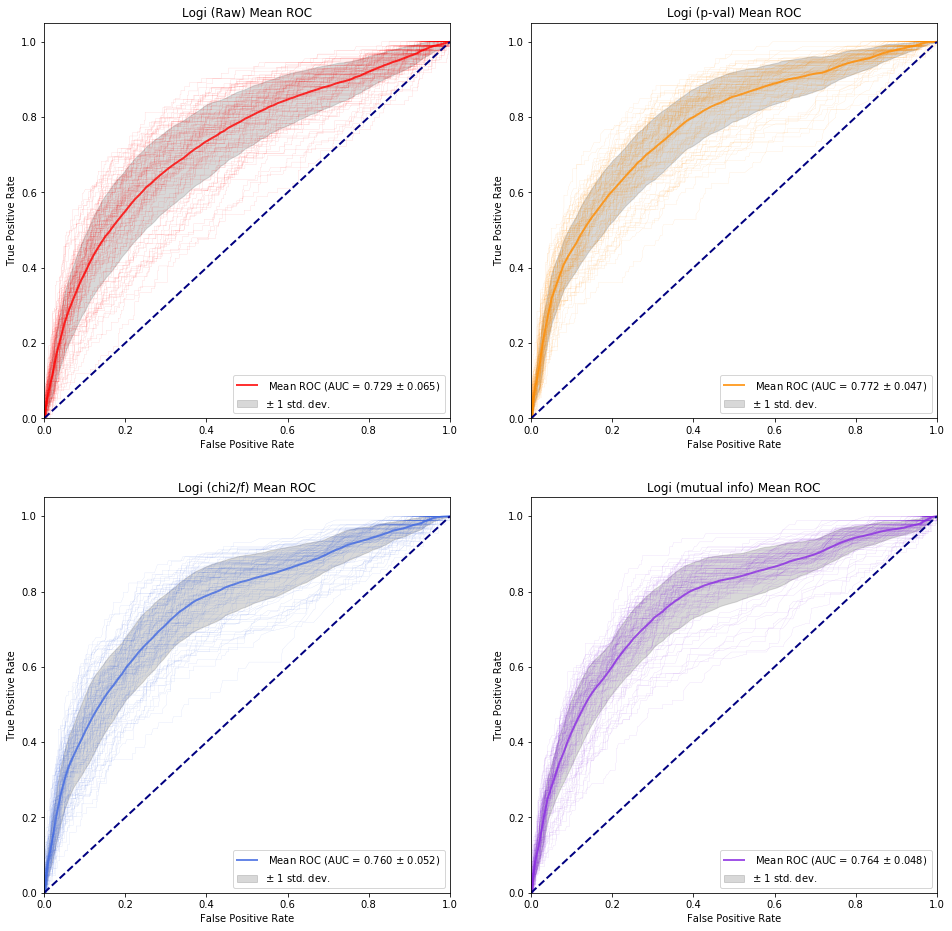

In [99]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seed_x_train,seed_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seed_x_train[p_seed],seed_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seed_x_train[chi2_seed],seed_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seed_x_train[mutual_seed],seed_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seed_4x.png')


plt.show()

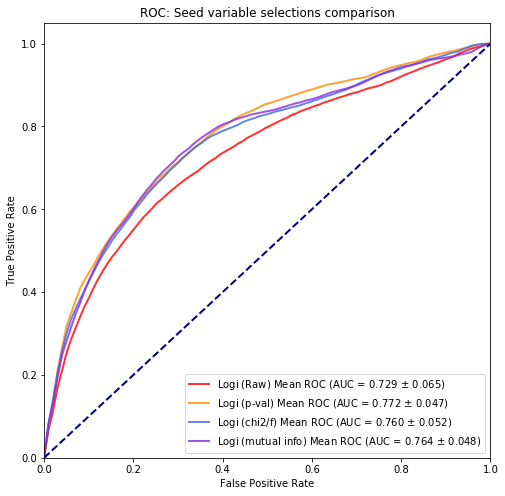

In [100]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()

In [101]:
def test_results(x_train, y_train, x_test, y_test):
    x_train, y_train = downsample(x_train, y_train,rs)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    logi.fit(x_train, y_train)
    acc = logi.score(x_test, y_test)
    y_pred = logi.predict(x_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
    tpr = cm[0][0]/np.sum(cm[0])
    tnr = cm[1][1]/np.sum(cm[1])
    return(list(np.round([acc,tpr,tnr],3)))

In [102]:
test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test)

[0.655, 0.588, 0.67]

In [103]:
test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test)

[0.715, 0.588, 0.743]

In [104]:

test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test)

[0.702, 0.529, 0.74]

In [105]:
test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)

[0.7, 0.559, 0.73]

In [107]:
data = [
    ["Seed Raw"] + test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test),
    ["Seed P-value"] + test_results(seed_x_train[p_seed], seed_y_train, seed_x_test[p_seed], seed_y_test),
    ["Seed Chi2/F"] + test_results(seed_x_train[chi2_seed], seed_y_train, seed_x_test[chi2_seed], seed_y_test),
    ["Seed Mutual"] + test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df

,Method,Test Accuracy,TPR,TNR
0,Seed Raw,0.655,0.588,0.670
1,Seed P-value,0.715,0.588,0.743
2,Seed Chi2/F,0.702,0.529,0.740
3,Seed Mutual,0.700,0.559,0.730


In [108]:
logi = sm.Logit(seed_y_train, seed_x_train[chi2_seed]).fit(method='bfgs',maxiter=1000) # The maxiter is increased to help convergence for seed

Optimization terminated successfully.
         Current function value: 0.430306
         Iterations: 110
         Function evaluations: 119
         Gradient evaluations: 116


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [109]:
print(logi.summary())

                           Logit Regression Results                           
Dep. Variable:            raised_2mil   No. Observations:                 1529
Model:                          Logit   Df Residuals:                     1519
Method:                           MLE   Df Model:                            9
Date:                Fri, 05 Jun 2020   Pseudo R-squ.:                 0.08481
Time:                        17:21:35   Log-Likelihood:                -657.94
converged:                       True   LL-Null:                       -718.91
Covariance Type:            nonrobust   LLR p-value:                 5.353e-22
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
size_numeric                           0.0044      0.002      2.634      0.008       0.001       0.008
years                                 -0.3148      0.015   

In [110]:
seriesA.shape, seed.shape

((534, 17), (1912, 17))

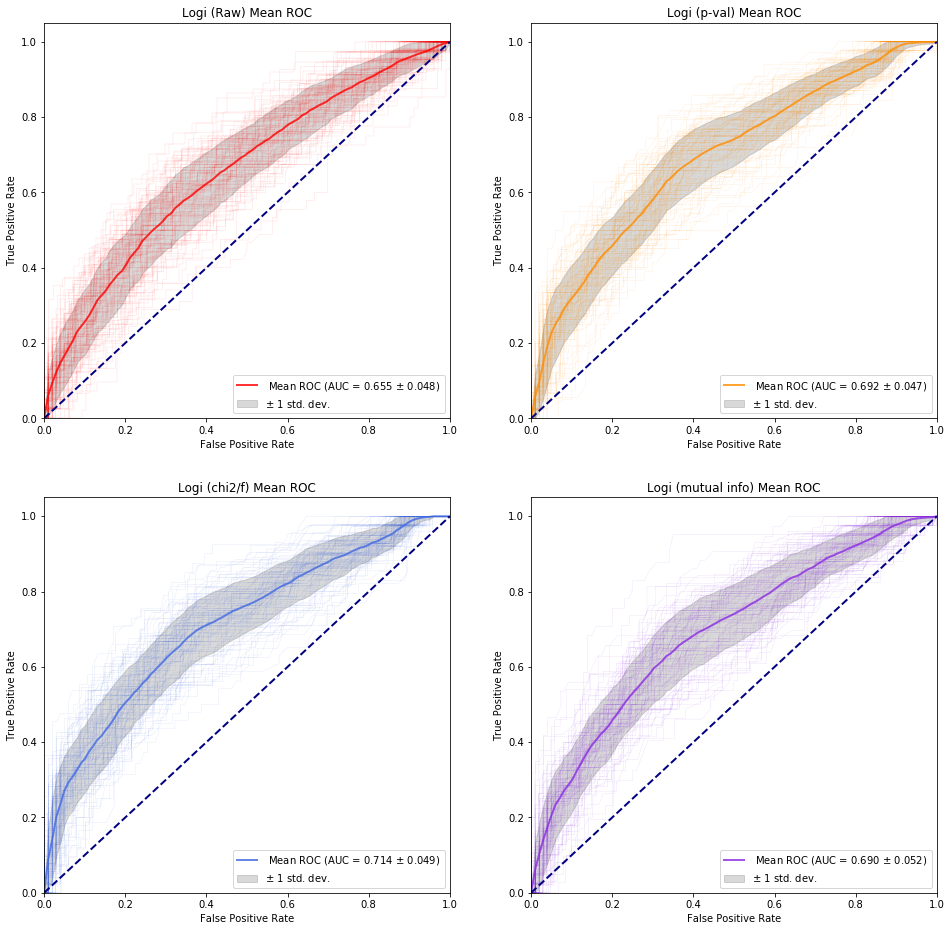

In [111]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seriesA_x_train,seriesA_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(seriesA_x_train[p_seriesA],seriesA_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seriesA_x_train[chi2_seriesA],seriesA_y_train,colors[2],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(seriesA_x_train[mutual_seriesA],seriesA_y_train,colors[3],show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seriesA_4x.png')

plt.show()

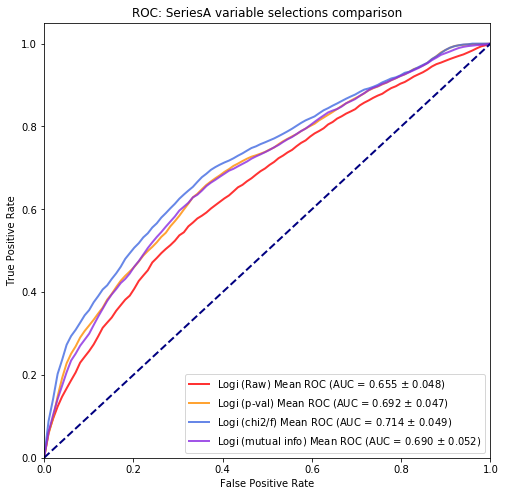

In [112]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: SeriesA variable selections comparison")
plt.savefig('seriesA_all.png')


plt.show()

In [113]:
data = [
    ["SeriesA Raw"] + test_results(seriesA_x_train, seriesA_y_train, seriesA_x_test, seriesA_y_test),
    ["SeriesA P-value"] + test_results(seriesA_x_train[p_seriesA], seriesA_y_train, seriesA_x_test[p_seriesA], seriesA_y_test),
    ["SeriesA Chi2/F"] + test_results(seriesA_x_train[chi2_seriesA], seriesA_y_train, seriesA_x_test[chi2_seriesA], seriesA_y_test),
    ["SeriesA Mutual"] + test_results(seriesA_x_train[mutual_seriesA], seriesA_y_train, seriesA_x_test[mutual_seriesA], seriesA_y_test)]
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df

,Method,Test Accuracy,TPR,TNR
0,SeriesA Raw,0.654,0.435,0.714
1,SeriesA P-value,0.710,0.391,0.798
2,SeriesA Chi2/F,0.710,0.391,0.798
3,SeriesA Mutual,0.701,0.391,0.786
